# OpenAI podojo docs
This takes a txt file as an input and generates and embeddings file

In [1]:
import pandas as pd
from io import open
import numpy as np

### Define the import file

In [2]:
filename = 'all-files'

In [3]:
# variables
import_filename = 'text-cleaned/' + filename + '.txt'
processed_filename = 'processed/' + filename + '.csv'
embeddings_filename = 'embeddings/' + filename + '.csv'

In [4]:
# Load text file as plain text
with open(import_filename, encoding='utf-8') as f:
    text = f.read()

In [5]:
# Convert text to a pandas series
text_series = pd.Series(text.split('\n'))

In [6]:
print(text_series)

0                                 WHAT IS A CULTURE MAP?
1      With the Culture Map you can visualize the cul...
2                                                       
3      The Culture Map is utilized in various situati...
4                                                       
                             ...                        
245                                                     
246    This may sound trivial but we have seen so man...
247                                                     
248                              There is no good or bad
249    So setting the context and framing the task as...
Length: 250, dtype: object


In [7]:
# remove spaces
text_series = text_series.str.strip()
# remove empty lines full of spaces
text_series = text_series.apply(lambda x: x.strip())

In [8]:
# remove empty lines
text_series = text_series.str.strip().replace('', np.nan).dropna()
text_series.dropna(inplace=True)

In [9]:
print(text_series)

0                                 WHAT IS A CULTURE MAP?
1      With the Culture Map you can visualize the cul...
3      The Culture Map is utilized in various situati...
5          Developing hypotheses during a change process
6      Identifying hidden assumptions during a team r...
                             ...                        
243                               Three modes of working
244    Observing customers, designing value propositi...
246    This may sound trivial but we have seen so man...
248                              There is no good or bad
249    So setting the context and framing the task as...
Length: 168, dtype: object


In [10]:
text_series = text_series.str.replace('\n', '')
text_series = text_series.str.replace('\\n', '', regex=True)
text_series = text_series.str.replace('-', ' ').str.replace('_', ' ')
text_series = text_series.str.replace('  ', ' ')
#put a space between lowercase and uppercase letters
text_series = text_series.str.replace(r'([a-z])([A-Z])', r'\1 \2', regex=True)
#put space between ? and character
text_series = text_series.str.replace(r'(\?)([^\s])', r'\1 \2', regex=True)
text_series = text_series.str.replace(r'\.([A-Z])', r'. \1', regex=True)

In [11]:
text_series.head()

0                               WHAT IS A CULTURE MAP?
1    With the Culture Map you can visualize the cul...
3    The Culture Map is utilized in various situati...
5        Developing hypotheses during a change process
6    Identifying hidden assumptions during a team r...
dtype: object

### Convert series to DF and save as csv

In [12]:
df = text_series.to_frame()
df.columns = ['text']
print(df)

                                                  text
0                               WHAT IS A CULTURE MAP?
1    With the Culture Map you can visualize the cul...
3    The Culture Map is utilized in various situati...
5        Developing hypotheses during a change process
6    Identifying hidden assumptions during a team r...
..                                                 ...
243                             Three modes of working
244  Observing customers, designing value propositi...
246  This may sound trivial but we have seen so man...
248                            There is no good or bad
249  So setting the context and framing the task as...

[168 rows x 1 columns]


In [13]:
df.to_csv(processed_filename, index=False)

### Tokenize 

In [14]:
import tiktoken

In [15]:
# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

In [16]:
# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

<AxesSubplot: >

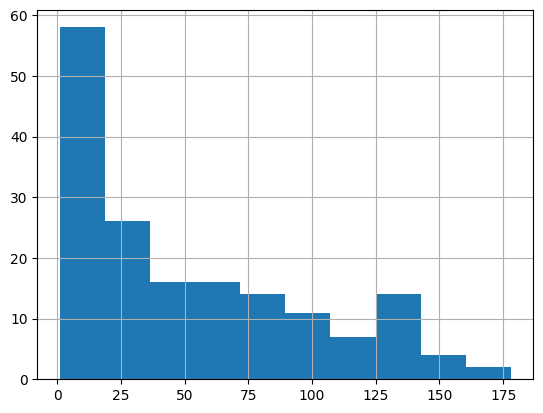

In [17]:
# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [18]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<AxesSubplot: >

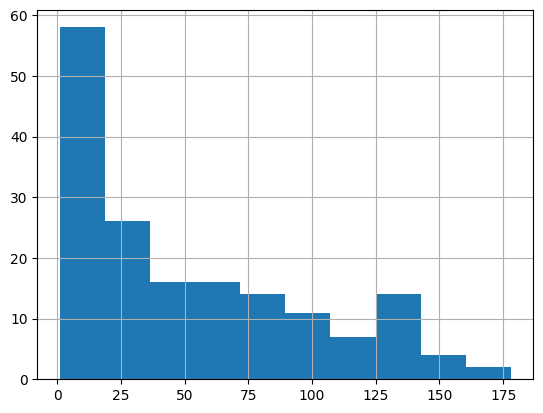

In [19]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

### Create embeddings

In [20]:
import openai
from dotenv import load_dotenv
import os

In [21]:
load_dotenv(".env")
openai.api_key = os.getenv("OPENAI_API_KEY")

In [22]:
df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

df.to_csv(embeddings_filename)
df.head()

,text,n_tokens,embeddings
0,WHAT IS A CULTURE MAP?,8,"[-0.021535981446504593, -0.0006195246824063361..."
1,With the Culture Map you can visualize the cul...,37,"[-0.03665049001574516, 0.002686046762391925, 0..."
2,The Culture Map is utilized in various situati...,11,"[-0.019889313727617264, 0.013448194600641727, ..."
3,Developing hypotheses during a change process,7,"[0.002740309340879321, 0.00392221100628376, -0..."
4,Identifying hidden assumptions during a team r...,8,"[0.010800959542393684, -0.013984978199005127, ..."


In [23]:
import numpy as np

In [24]:
from openai.embeddings_utils import distances_from_embeddings

In [25]:
df=pd.read_csv(embeddings_filename, index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,WHAT IS A CULTURE MAP?,8,"[-0.021535981446504593, -0.0006195246824063361..."
1,With the Culture Map you can visualize the cul...,37,"[-0.03665049001574516, 0.002686046762391925, 0..."
2,The Culture Map is utilized in various situati...,11,"[-0.019889313727617264, 0.013448194600641727, ..."
3,Developing hypotheses during a change process,7,"[0.002740309340879321, 0.00392221100628376, -0..."
4,Identifying hidden assumptions during a team r...,8,"[0.010800959542393684, -0.013984978199005127, ..."


In [26]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [27]:
def answer_question(
    df,
    model="text-davinci-003",
    question="what is lean?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know. This is not discussed in the book\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [28]:
answer_question(df, question="What is a good way for teams to get started?")

'Divide the participants into small groups and think of this as a brainstorming session without limitations. Encourage your team to explore different variations of the same problem, no matter how unlikely or absurd they may seem. For example, consider scenarios such as a monster eating a team member or an elephant eating your guest of honor. Also, explore very different, unrelated problems, such as what to do if no one shows up to your event, your website goes down, or the most important person backs out on you. Exercise instructions: "You\'re team is telling your stakeholders you\'re going to use Scrum. They asked you "what is Scrum" and you ahve 30 seconds to explain. After the 30 seconds is over, the next team adds to'

In [29]:
answer_question(df, question="How can I find out if my idea works?")

'There are several methods for validating an idea, such as assessment, fact finding, tests, and experiments. These methods can include stakeholder reviews, competitor analysis, business modeling, human operated tests, prototyping, and large scale tests. Additionally, the feedback from customer interviews, market research, and low fidelity prototypes can help to assess the effectiveness of the approach and identify any changes that need to be made.'

In [30]:
answer_question(df, question="Was ist Crazy8")

'Crazy8 is a method of brainstorming and idea generation developed by Jake Knapp. It involves sketching out 8 ideas in 8 minutes.'